#import

In [ ]:
import os
import re
import cv2
import glob
import keras
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
from scipy import signal
from matplotlib.pyplot import *
from skimage import color
from skimage.io import imread
from keras import backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from skimage.transform import resize
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Input,Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

%matplotlib inline
tf.__version__

'2.8.0'

##Entrenamiento del modelo

Se conecta con google drive para cargar y guardar los nuevos modelos obtenidos del entrenamiento

**Se debe aceptar el permiso que se muestra a continuación para guardar los modelos creados**

Si no se acepta el permiso para para ver, editar, crear y eliminar archivos en su google drive entonces no se guardaran los nuevos modelos ni podrá cargar otros modelos

Se recomienda crear un acceso directo de la carpeta llamada models en "Mi unidad" de drive, de está forma se pueden usar los modelos de esa carpeta y guardar los nuevos en el mismo lugar.

In [ ]:
from google.colab import drive
import os
saveModel = False
try:
  drive.mount('/content/drive')
except:
  print("Si quiere guardar los modelos creados debe aceptar el permiso para para ver, editar, crear y eliminar archivos en su google drive")
try:
  if os.path.isdir('./drive/MyDrive/models'):
    print("\nLos modelos se guardarán en su directorio models")
    saveModel = True
  else:
    os.mkdir('./drive/MyDrive/models')
    print("\nLos modelos se guardarán en un directorio llamado models en su unidad de drive")
    saveModel = True
except:
    saveModel = False
    print("\nNo se tiene permiso para acceder a drive")

Mounted at /content/drive

Los modelos se guardarán en su directorio models


Lineas y funciones necesarias para en entrenamiento

In [ ]:
#@title elija el número de modelo que desea cargar { display-mode: "form" }

#Número del modelo que será cargado, Si ese modelo no existe se buscará uno anterior en la misma ubicación
numModel =  13#@param {type:"integer"}


!git clone https://github.com/Kadyha/Brain_Tumor_Detection_MRI.git

noTumorImages = [cv2.imread(file).mean(axis=2) for file in glob.glob("Brain_Tumor_Detection_MRI/data/no/*.jpg")]
yesTumorImages = [cv2.imread(file).mean(axis=2) for file in glob.glob("Brain_Tumor_Detection_MRI/data/yes/*.jpg")]

def get_img(images):
  for i in range(len(images)):
    images[i] = resize(images[i], output_shape=(224,224,3))
    images[i] = ((images[i]-np.min(images[i]))/(np.max(images[i])-np.min(images[i]))*255).astype(int)
  return images

noTumorImages = get_img(noTumorImages)
yesTumorImages = get_img(yesTumorImages)

X = np.array(noTumorImages + yesTumorImages, dtype=np.uint8)
y = np.concatenate((np.zeros(len(noTumorImages)), np.ones(len(yesTumorImages))), axis=None)

XTrainTest, XVal, yTrainTest, yVal = train_test_split(X,y,test_size=0.1)
XTrain, XTest, yTrain, yTest = train_test_split(XTrainTest,yTrainTest,test_size=0.2)

def get_model(compile=True):
    inputs = tf.keras.Input(shape=(224,224,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(2, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model
model = get_model()

RES_DIR = './drive/MyDrive/models/'
FILE_P = '%sBrain_tumor_detector%d'
FILE_PATH = ''+ FILE_P + '.h5'
if saveModel == False:
  print('\nNo se guardarán modelos ya que no se acepto el permiso para para ver, editar, crear y eliminar archivos en su google drive')
else:
  for i in range(numModel):
    if os.path.isfile(FILE_PATH % (RES_DIR, numModel-i)) and saveModel:
      model = keras.models.load_model(FILE_PATH % (RES_DIR, numModel-i))
      print('\nSe cargó el modelo número ', numModel-i)
      numModel = numModel-i+1
      break
numModel = 99  
for i in range(numModel):
  if os.path.isfile(FILE_PATH % (RES_DIR, numModel-i)) and saveModel:
    numModel = numModel-i+1
    break
      
def train(model, batch_size, epochs,  numModel=0, model_name=""):
  callback = ModelCheckpoint((FILE_PATH % (RES_DIR, numModel)), monitor='loss', verbose=1,
             save_best_only=True, mode='auto', save_freq=int((len(XTrain)/batch_size)+1))
  model.fit(XTrain, yTrain, epochs=epochs, callbacks=[callback],
            batch_size=batch_size,
            validation_data=(XTest, yTest))
  metrics = model.evaluate(XTest, yTest)
  return {k:v for k,v in zip (model.metrics_names, metrics)}

fatal: destination path 'Brain_Tumor_Detection_MRI' already exists and is not an empty directory.

Se cargó el modelo número  11


Entrenamiento del modelo

In [ ]:
train(model, batch_size=10, epochs=10, numModel = numModel, model_name="Brain_tumor_detector")

Epoch 1/10
216/216 [==============================] - 2774s 13s/step - loss: 0.6351 - accuracy: 0.6259 - val_loss: 0.6023 - val_accuracy: 0.6704
Epoch 2/10

Epoch 2: loss improved from inf to 0.61910, saving model to ./drive/MyDrive/models/Brain_tumor_detector12.h5
216/216 [==============================] - 2741s 13s/step - loss: 0.6088 - accuracy: 0.6546 - val_loss: 0.9475 - val_accuracy: 0.6722
Epoch 3/10
  1/216 [..............................] - ETA: 42:32 - loss: 1.1505 - accuracy: 0.2000
Epoch 3: loss did not improve from 0.61910
216/216 [==============================] - 2710s 13s/step - loss: 0.7163 - accuracy: 0.6699 - val_loss: 0.5832 - val_accuracy: 0.6630
Epoch 4/10
  2/216 [..............................] - ETA: 41:58 - loss: 14.3138 - accuracy: 0.5000
Epoch 4: loss did not improve from 0.61910
216/216 [==============================] - 2707s 13s/step - loss: 0.9383 - accuracy: 0.6111 - val_loss: 0.6780 - val_accuracy: 0.5963
Epoch 5/10
  3/216 [...........................

{'accuracy': 0.6555555462837219, 'loss': 0.5709894895553589}

##Evaluación del modelo

####Perdida y exactitud

In [ ]:
test_loss, test_acc = model.evaluate(XTest, yTest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

17/17 [==============================] - 167s 10s/step - loss: 0.5710 - accuracy: 0.6556
Test loss: 0.5709894895553589
Test accuracy: 0.6555555462837219


In [ ]:
val_loss, val_acc = model.evaluate(XVal, yVal)
print('Val loss:', val_loss)
print('Val accuracy:', val_acc)

####Predicciones

In [ ]:
predictions = model.predict(XVal)

Predicción de un grupo de imágenes

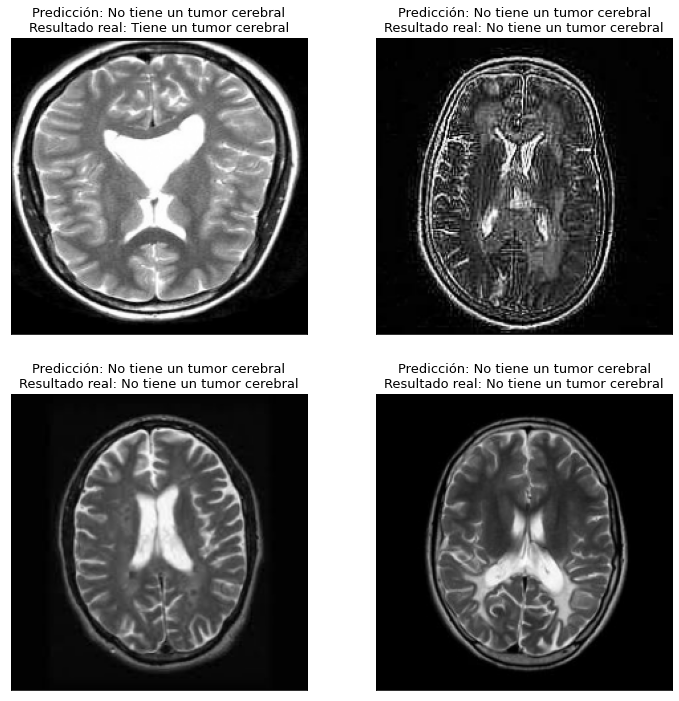

In [ ]:
rows = 2  #Número de imágenes en las filas
columns = 2  #Número de imágenes en las columnas
fig = plt.figure(figsize=(12, 12))
for i in range(1, columns*rows +1):
  nimg = np.random.randint(len(XVal)) # Número de la imagen que se desea predecir
  if np.argmax(predictions[nimg]) == 0:
    title = "Predicción: No tiene un tumor cerebral"
  else:
    title = "Predicción: Tiene un tumor cerebral"
  if yVal[nimg] == 0:
    subtitle = "Resultado real: No tiene un tumor cerebral"
  else:
    subtitle = "Resultado real: Tiene un tumor cerebral"
  text = (title+"\n"+subtitle)
  fig.add_subplot(rows, columns, i)
  plt.xticks([]), plt.yticks([])
  plt.title(text,fontsize= 13)
  plt.imshow(XVal[nimg], cmap=plt.cm.Greys_r)
plt.show()

Predicción individual

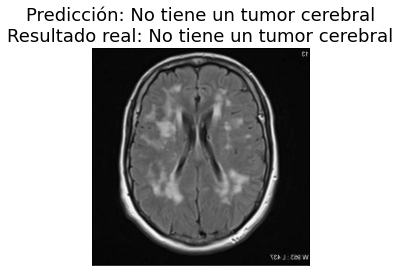

In [ ]:
nimg = np.random.randint(len(XVal)) # Número de la imagen que se desea predecir
#nimg = input()
if np.argmax(predictions[nimg]) == 0:
  title = "Predicción: No tiene un tumor cerebral"
else:
  title = "Predicción: Tiene un tumor cerebral"
if yVal[nimg] == 0:
  subtitle = "Resultado real: No tiene un tumor cerebral"
else:
  subtitle = "Resultado real: Tiene un tumor cerebral"
text = (title+"\n"+subtitle)
plt.xticks([]), plt.yticks([])
plt.title(text,fontsize= 18)
plt.imshow(XVal[nimg], cmap=plt.cm.Greys_r)